<a href="https://colab.research.google.com/github/rizqi-maulidi/Sentiment_Analysis_Gojek/blob/main/ModelSentimentGojek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re
import string
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D


In [ ]:
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stop words) dalam berbagai bahasa.

[nltk_data] Downloading package punkt to C:\Users\Rizqi
[nltk_data]     Maulidi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rizqi
[nltk_data]     Maulidi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading Dataset

In [ ]:
app_review = pd.read_csv('ulasan_gojek.csv')
# Membuat DataFrame dari hasil scrapreview
app_reviews_df = pd.DataFrame(app_review)
app_reviews_df.head()

,Review,Rating,Tanggal,Likes
0,terlalu terlalu terlalu... apk yg tidak bisa d...,1,2022-04-21 20:37:07,1
1,"Gak usah pasang tarif tarif hemat, soalnya par...",1,2025-03-21 21:44:12,251
2,tinggal 2menit lg driver sampe di lokasi tiba-...,1,2025-03-26 07:35:56,112
3,"Setelah Update makin ancur aja nih, dalam 20 h...",5,2025-04-05 23:22:33,15
4,"Ongkir mahal, pajak aplikasi gede, biaya aplik...",1,2025-03-20 00:43:10,107


In [ ]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76500 entries, 0 to 76499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Review   76500 non-null  object
 1   Rating   76500 non-null  int64 
 2   Tanggal  76500 non-null  object
 3   Likes    76500 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


# Preprocessing

## Data Cleaning

In [ ]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

In [ ]:
# Menampilkan informasi tentang DataFrame clean_df setelah membersihkan nilai yang hilang (NaN)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76500 entries, 0 to 76499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Review   76500 non-null  object
 1   Rating   76500 non-null  int64 
 2   Tanggal  76500 non-null  object
 3   Likes    76500 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [ ]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [ ]:
# URL kamus stopword kustom
url_stopwords = 'https://raw.githubusercontent.com/rizqi-maulidi/UAS-Deep-Learning/refs/heads/main/kamusstopword.txt'

def get_custom_stopwords(url):
    """Mengunduh daftar stopword kustom dari URL."""
    response = requests.get(url)
    if response.status_code == 200:
        custom_stopwords = response.text.split()
        return set(custom_stopwords)
    else:
        print(f"Error: Gagal mengunduh stopword dari {url}")
        return set()

# Mengunduh stopword kustom
custom_stopwords = get_custom_stopwords(url_stopwords)

# Menggabungkan stopword dari NLTK (Indonesia & Inggris) dengan stopword kustom
stopwords_id = set(stopwords.words('indonesian'))
stopwords_en = set(stopwords.words('english'))
all_stopwords = stopwords_id | stopwords_en | custom_stopwords

def cleaningText(text):
    """Membersihkan teks dari mentions, hashtag, RT, URL, angka, dan karakter khusus."""
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Hapus mention (@username)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Hapus hashtag (#hashtag)
    text = re.sub(r'RT[\s]+', '', text)  # Hapus "RT"
    text = re.sub(r"http\S+|www\S+", '', text)  # Hapus link
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Hapus karakter khusus

    text = text.replace('\n', ' ')  # Ganti newline dengan spasi
    text = text.strip()  # Hapus spasi berlebih di awal/akhir teks
    return text

def casefoldingText(text):
    """Mengubah teks menjadi huruf kecil semua."""
    return text.lower()

def tokenizingText(text):
    """Memisahkan teks menjadi token (kata per kata)."""
    return word_tokenize(text)

def filteringText(words):
    """Menghapus stopwords dari teks."""
    return [word for word in words if word not in all_stopwords]

def stemmingText(words):
    """Melakukan stemming pada teks menggunakan Sastrawi."""
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(word) for word in words]

def toSentence(words):
    """Mengubah list kata menjadi kalimat utuh."""
    return ' '.join(words)


In [ ]:
#Ambil daftar slang dari google drive
import requests
import json

# ID file dari Google Drive
file_id = "1oJHjK4Lk_2Jr7sx74UKzYJcFFCxG9lKx"

# URL Google Drive yang telah diperbarui
url = f"https://drive.google.com/uc?id={file_id}"

response = requests.get(url)
slangwords = json.loads(response.text)

print(slangwords)


{'@': 'di', 'abis': 'habis', 'wtb': 'beli', 'masi': 'masih', 'wts': 'jual', 'wtt': 'tukar', 'bgt': 'banget', 'maks': 'maksimal', 'plisss': 'tolong', 'bgttt': 'banget', 'indo': 'indonesia', 'bgtt': 'banget', 'ad': 'ada', 'rv': 'redvelvet', 'plis': 'tolong', 'pls': 'tolong', 'cr': 'sumber', 'cod': 'bayar ditempat', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku', 'akkoh': 'aku', 'akuwh': 'aku', 'alay': 'norak', 'alow': 'halo', 'ambilin': 'ambilkan', 'ancur': 'hancur', 'anjrit': 'anjing', 'anter': 'antar', 'ap2': 'apa-apa', 'apasih': 'apa sih', 'apes': 'sial', 'aps': 'apa', 'aq': 'saya', 'aquwh': 'aku', 'asbun': 'asal bunyi', 'aseekk': 'asyik', 'asekk': 'asyik', 'asem': 'asam', 'aspal': 'asli tetapi palsu', 'astul': 'asal tulis', 'ato': 'atau', 'au ah': 'tidak mau tahu', 'awak': 'saya', 'ay': 'sayang', 'ayank': 'sayang', 'b4': 'sebelum', 'bakalan': 'akan', 'bandes': 'bantuan desa', 'bangedh': 'banget

In [ ]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
clean_df

,Review,Rating,Tanggal,Likes
0,terlalu terlalu terlalu... apk yg tidak bisa di percaya. kuota cepat abis minta update terus. tp bug tmbah banyak. hp jd lelet !!!.. kok bisa nyuri data pribadi ya... diliat dari apk yg terus berjln dilatar belakang dan terus mengirim data. tp g tau data ap yg dikirim ?? wah wah wah... bahaya bobol bisa atm wkwkwk,1,2022-04-21 20:37:07,1
1,"Gak usah pasang tarif tarif hemat, soalnya para driver nya gak ada yang mau ambil orderan, dengan alasan gak sesuai dengan harga, dan bahasa mereka merendahkan costumer, karena pesen yg paket hemat, trs knp di adain paket hemat, yg salah yg punya aplikasi lah, pengen kasih promo tapi para driver nya gak mau.",1,2025-03-21 21:44:12,251
2,"tinggal 2menit lg driver sampe di lokasi tiba-tiba dibatalin otomatis sama aplikasinya!!! tau tau udah mencari driver yg baru, dan ini kejadian gak sekali dua kali tapi sering! map jg sering di arahin ke jalan yg sulit di lewati mobil!! alhasil banyak yg batalin! komplain via chat cuma bot doang, Kita yg mo complain gak bisa ketik sendiri masalahnya, mo complain lewat email atau tlp jg gak bisa!!! aplikasi gak niat terima komplain!!!",1,2025-03-26 07:35:56,112
3,"Setelah Update makin ancur aja nih, dalam 20 hari 3 kali update dan setelah Update yg ke 3 kalinya aplikasi gak bisa di buka selalu kembali menutup dengan sendirinya belum muncul vitur2 yg ada pada aplikasi, padahal masih kompatibel dengan perangkat yg digunakan.Tolonglah kepada pengembang Aplikasi untuk segera diperbaiki....",5,2025-04-05 23:22:33,15
4,"Ongkir mahal, pajak aplikasi gede, biaya aplikasi juga gede , jarang ada voucher gratis ongkir padahal pengguna lama, durasi pesan antar bisa ampai sejam gak bisa dicancel, giliran detik-detik terakhir berharap cancel otomatis malah nyantol driver padahal udah ada opsi lain busuk",1,2025-03-20 00:43:10,107
...,...,...,...,...
76495,Jelek nge download gak cepet dan juga instal nya lama banget,1,2022-05-20 19:17:45,0
76496,Aplikasi gak konsisten ngasih voucer kok tiba2 hilang,1,2020-02-17 12:57:40,0
76497,"Enak maen donwload"" tan paket habis download nggak kujung bisa,, ahahah pakok nya the best lah biasa habisin paket",1,2020-08-15 01:03:44,0
76498,Ok terimakasih banyak sudah bagus sekarang Go-Jek mudah pesan ojek nya meskipun ujan tetap ada datang salut sama pengemudinya terimakasih,5,2024-03-08 17:10:22,1


In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [ ]:
clean_df

,Review,Rating,Tanggal,Likes,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,terlalu terlalu terlalu... apk yg tidak bisa di percaya. kuota cepat abis minta update terus. tp bug tmbah banyak. hp jd lelet !!!.. kok bisa nyuri data pribadi ya... diliat dari apk yg terus berjln dilatar belakang dan terus mengirim data. tp g tau data ap yg dikirim ?? wah wah wah... bahaya bobol bisa atm wkwkwk,1,2022-04-21 20:37:07,1,terlalu terlalu terlalu apk yg tidak bisa di percaya kuota cepat abis minta update terus tp bug tmbah banyak hp jd lelet kok bisa nyuri data pribadi ya diliat dari apk yg terus berjln dilatar belakang dan terus mengirim data tp g tau data ap yg dikirim wah wah wah bahaya bobol bisa atm wkwkwk,terlalu terlalu terlalu apk yg tidak bisa di percaya kuota cepat abis minta update terus tp bug tmbah banyak hp jd lelet kok bisa nyuri data pribadi ya diliat dari apk yg terus berjln dilatar belakang dan terus mengirim data tp g tau data ap yg dikirim wah wah wah bahaya bobol bisa atm wkwkwk,terlalu terlalu terlalu apk yang tidak bisa di percaya kuota cepat habis minta update terus tapi bug tambah banyak hp jadi lambat kok bisa nyuri data pribadi iya diliat dari apk yang terus berjln dilatar belakang dan terus mengirim data tapi g tahu data apa yang dikirim wah wah wah bahaya bobol bisa atm wkwkwk,"[terlalu, terlalu, terlalu, apk, yang, tidak, bisa, di, percaya, kuota, cepat, habis, minta, update, terus, tapi, bug, tambah, banyak, hp, jadi, lambat, kok, bisa, nyuri, data, pribadi, iya, diliat, dari, apk, yang, terus, berjln, dilatar, belakang, dan, terus, mengirim, data, tapi, g, tahu, data, apa, yang, dikirim, wah, wah, wah, bahaya, bobol, bisa, atm, wkwkwk]","[apk, percaya, kuota, cepat, habis, update, bug, hp, lambat, nyuri, data, pribadi, iya, diliat, apk, berjln, dilatar, mengirim, data, g, data, dikirim, bahaya, bobol, atm]",apk percaya kuota cepat habis update bug hp lambat nyuri data pribadi iya diliat apk berjln dilatar mengirim data g data dikirim bahaya bobol atm
1,"Gak usah pasang tarif tarif hemat, soalnya para driver nya gak ada yang mau ambil orderan, dengan alasan gak sesuai dengan harga, dan bahasa mereka merendahkan costumer, karena pesen yg paket hemat, trs knp di adain paket hemat, yg salah yg punya aplikasi lah, pengen kasih promo tapi para driver nya gak mau.",1,2025-03-21 21:44:12,251,Gak usah pasang tarif tarif hemat soalnya para driver nya gak ada yang mau ambil orderan dengan alasan gak sesuai dengan harga dan bahasa mereka merendahkan costumer karena pesen yg paket hemat trs knp di adain paket hemat yg salah yg punya aplikasi lah pengen kasih promo tapi para driver nya gak mau,gak usah pasang tarif tarif hemat soalnya para driver nya gak ada yang mau ambil orderan dengan alasan gak sesuai dengan harga dan bahasa mereka merendahkan costumer karena pesen yg paket hemat trs knp di adain paket hemat yg salah yg punya aplikasi lah pengen kasih promo tapi para driver nya gak mau,gak perlu pasang tarif tarif hemat soalnya para driver nya gak ada yang mau ambil orderan dengan alasan gak sesuai dengan harga dan bahasa mereka merendahkan costumer karena pesen yang paket hemat terus kenapa di adain paket hemat yang salah yang punya aplikasi lah pengen kasih promo tapi para driver nya gak mau,"[gak, perlu, pasang, tarif, tarif, hemat, soalnya, para, driver, nya, gak, ada, yang, mau, ambil, orderan, dengan, alasan, gak, sesuai, dengan, harga, dan, bahasa, mereka, merendahkan, costumer, karena, pesen, yang, paket, hemat, terus, kenapa, di, adain, paket, hemat, yang, salah, yang, punya, aplikasi, lah, pengen, kasih, promo, tapi, para, driver, nya, gak, mau]","[gak, pasang, tarif, tarif, hemat, driver, gak, ambil, orderan, alasan, gak, sesuai, harga, bahasa, merendahkan, costumer, pesen, paket, hemat, adain, paket, hemat, salah, aplikasi, pengen, kasih, promo, driver, gak]",gak pasang tarif tarif hemat driver gak ambil orderan alasan gak sesuai harga bahasa merendahkan co

## Labeling

In [ ]:
import csv
import requests
from io import StringIO

# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")


In [ ]:
# Function to determine sentiment polarity of tweets
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [ ]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    41500
positive    28902
neutral      6098
Name: count, dtype: int64


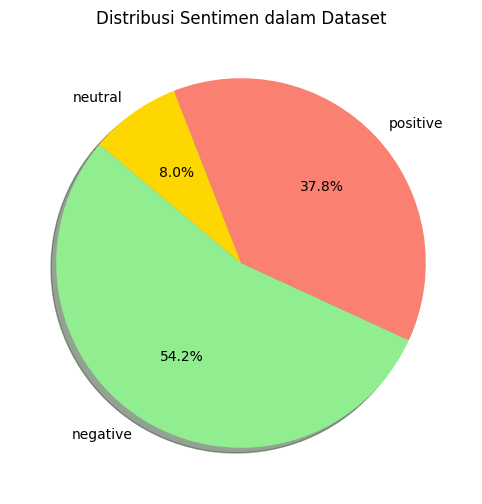

In [ ]:
import matplotlib.pyplot as plt

# Menghitung jumlah tiap sentimen
sentiment_counts = clean_df['polarity'].value_counts()
labels = sentiment_counts.index  # Label (positive, negative, neutral)
sizes = sentiment_counts.values  # Jumlah masing-masing sentimen
colors = ['lightgreen', 'salmon', 'gold']  # Warna untuk tiap sentimen

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Distribusi Sentimen dalam Dataset')
plt.show()


In [ ]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = clean_df[clean_df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1

In [ ]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
negative_tweets = clean_df[clean_df['polarity'] == 'negative']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
negative_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1

In [ ]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'neutral_tweets' yang hanya berisi tweet dengan polaritas negatif.
neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'neutral_tweets'.
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'neutral_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
neutral_tweets = neutral_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
neutral_tweets = neutral_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
neutral_tweets.index += 1

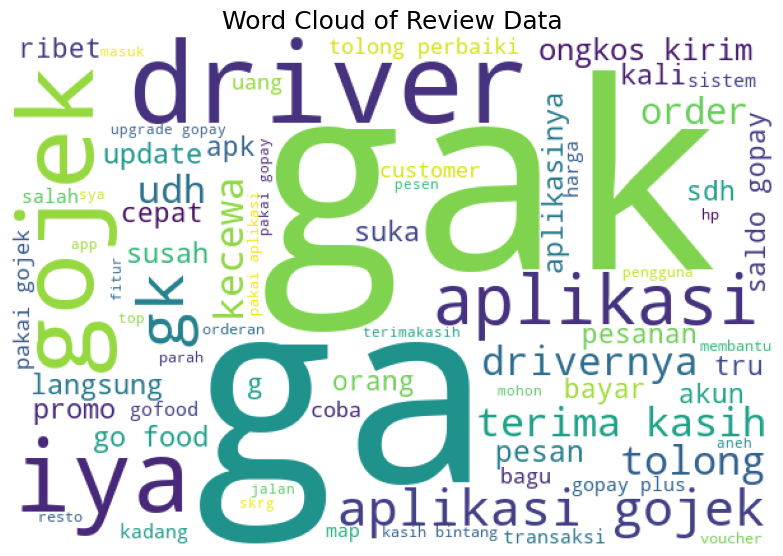

In [ ]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Review Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

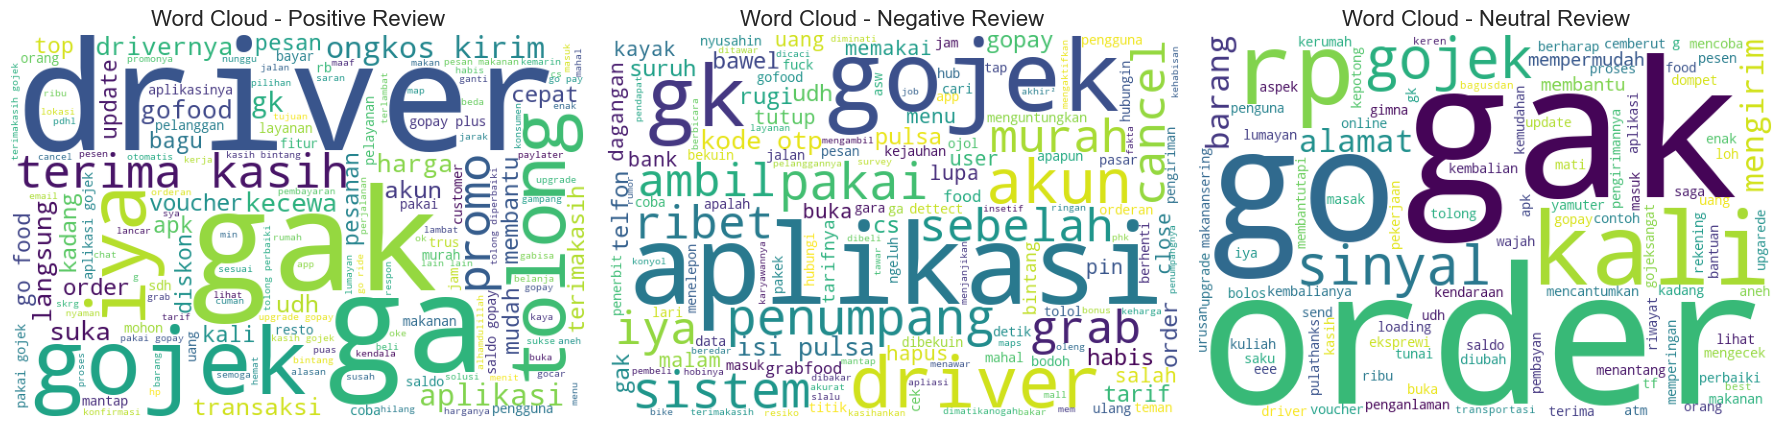

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(data, sentiment):
    """Membuat WordCloud untuk data berdasarkan sentimen."""
    list_words = ''
    for tweet in data['text_stopword']:
        for word in tweet:
            list_words += ' ' + word

    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    return wordcloud

# Generate word clouds
wordcloud_positive = generate_wordcloud(positive_tweets, 'Positive')
wordcloud_negative = generate_wordcloud(negative_tweets, 'Negative')
wordcloud_neutral = generate_wordcloud(neutral_tweets, 'Neutral')

# Visualisasi WordCloud dalam satu figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(wordcloud_positive)
axes[0].set_title('Word Cloud - Positive Review', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_negative)
axes[1].set_title('Word Cloud - Negative Review', fontsize=16)
axes[1].axis('off')

axes[2].imshow(wordcloud_neutral)
axes[2].set_title('Word Cloud - Neutral Review', fontsize=16)
axes[2].axis('off')

plt.tight_layout()
plt.show()


C:\Users\Rizqi Maulidi\AppData\Local\Temp\ipykernel_8732\1565757414.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  class_dist_plot = sns.countplot(x='polarity', data=clean_df, palette='pastel')


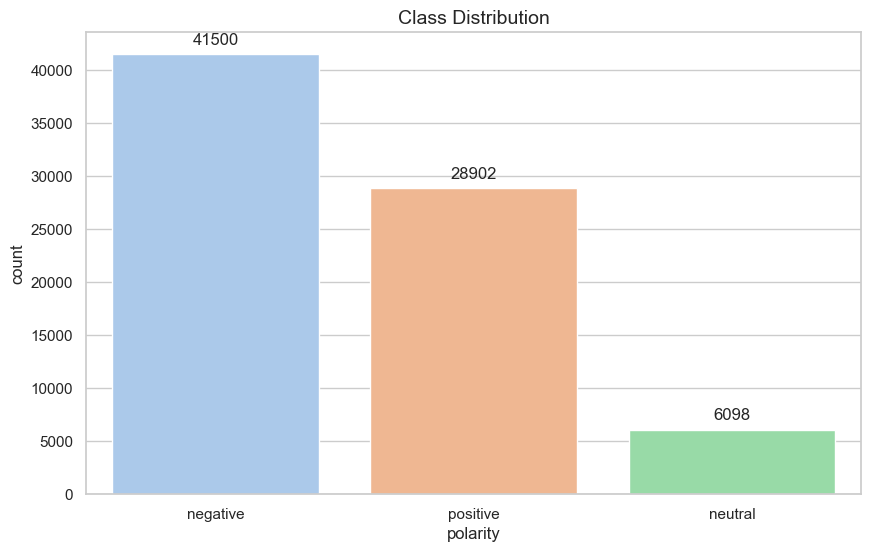

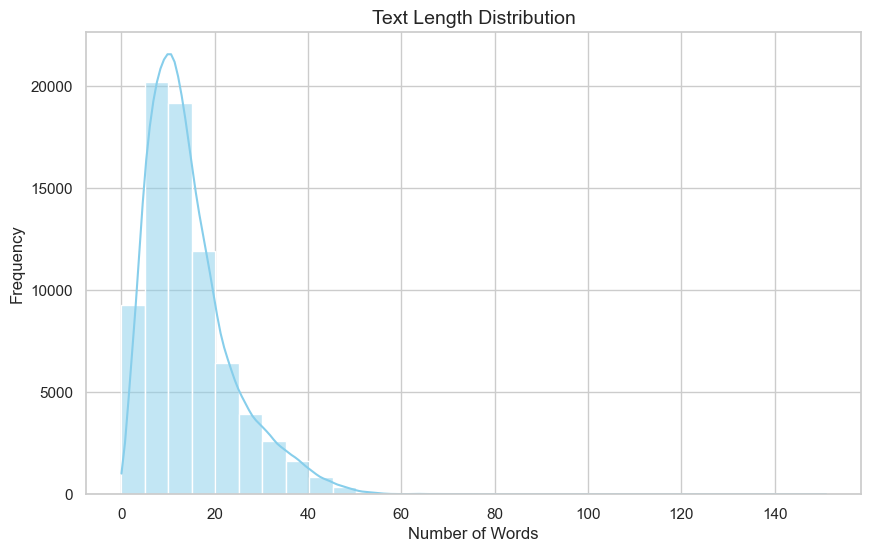

C:\Users\Rizqi Maulidi\AppData\Local\Temp\ipykernel_8732\1565757414.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jumlah', y='word', data=tfidf_df, palette='Blues_r')


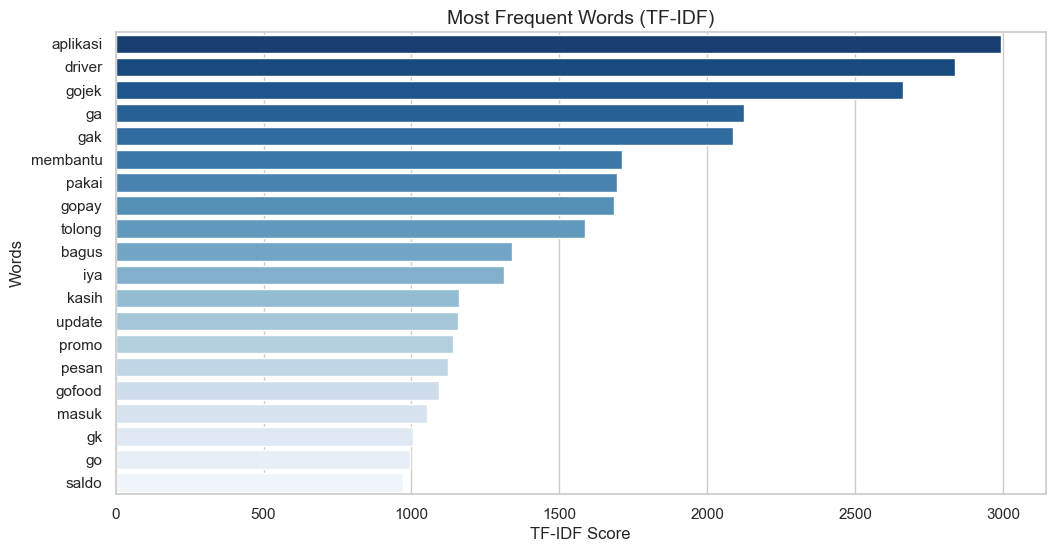

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Set style seaborn
sns.set(style="whitegrid")

# 1️⃣ Visualisasi distribusi kelas sentimen
plt.figure(figsize=(10, 6))
class_dist_plot = sns.countplot(x='polarity', data=clean_df, palette='pastel')
plt.title('Class Distribution', fontsize=14)

# Tambahkan angka di atas tiap bar
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

plt.show()

# 2️⃣ Visualisasi distribusi panjang teks
plt.figure(figsize=(10, 6))
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Text Length Distribution', fontsize=14)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 3️⃣ Visualisasi kata paling sering muncul dengan TF-IDF
plt.figure(figsize=(12, 6))

vectorizer = TfidfVectorizer(max_features=5000)  # Batasi hanya 5000 kata paling sering muncul
X = vectorizer.fit_transform(clean_df['text_akhir'])

# Hitung total skor TF-IDF per kata
tfidf_sum = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Buat DataFrame
tfidf_df = pd.DataFrame({'word': words, 'jumlah': tfidf_sum.astype(np.float32)})
tfidf_df = tfidf_df.sort_values(by='jumlah', ascending=False).head(20)

# Plot bar chart
sns.barplot(x='jumlah', y='word', data=tfidf_df, palette='Blues_r')
plt.title('Most Frequent Words (TF-IDF)', fontsize=14)
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()


# Modeling

Percobaan skema pelatihan dengan adanya 2 kombinasi yang berbeda.\
Model 1\
Pelatihan: LSTM,    Ekstraksi Fitur: Word Embedding,    Pembagian Data: 70/30\
Model 2\
Pelatihan: LSTM,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20\
Model 3\
Pelatihan: Transformers ,    Ekstraksi Fitur: Embedding ,    Pembagian Data: 80/20

## Pemodelan LSTM

## LSTM TF-IDF

In [ ]:
# Load Data
X = clean_df['text_akhir']
y = clean_df['polarity']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Convert Sparse Matrix to Dense Matrix
X_tfidf_dense = X_tfidf.toarray()

# Encode Sentiment Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_dense, y_encoded, test_size=0.3, random_state=42)

# Reshape Input for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM Model
model1 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile model1
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model1
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluasi Model
train_loss1, train_acc1 = model1.evaluate(X_train, y_train, verbose=0)
test_loss1, test_acc1 = model1.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc1 * 100:.2f}%")
print(f"Test Accuracy: {test_acc1 * 100:.2f}%")


c:\Users\Rizqi Maulidi\Project_Sentimen_Analiyst\envsentiment\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.7314 - loss: 0.6290 - val_accuracy: 0.8929 - val_loss: 0.2798
Epoch 2/5
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9127 - loss: 0.2438 - val_accuracy: 0.9057 - val_loss: 0.2562
Epoch 3/5
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.9328 - loss: 0.1915 - val_accuracy: 0.9153 - val_loss: 0.2382
Epoch 4/5
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9431 - loss: 0.1628 - val_accuracy: 0.9174 - val_loss: 0.2319
Epoch 5/5
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9498 - loss: 0.1461 - val_accuracy: 0.9162 - val_loss: 0.2414
Training Accuracy: 96.66%
Test Accuracy: 91.62%


## LSTM Word2Vec

In [ ]:
# Load data
X = clean_df['text_akhir']
y = clean_df['polarity']

# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(sequences, maxlen=100, padding='post')

# Prepare for Word2Vec: token list
sentences = [text.split() for text in X]

# Word2Vec
embedding_dim = 100
w2v_model2 = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Buat Embedding Matrix
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words and word in w2v_model2.wv:
        embedding_matrix[i] = w2v_model2.wv[word]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

# Build LSTM model2
model2 = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=100,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # ganti sesuai jumlah kelas
])

# Compile & Train
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit model2
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, callbacks=[early_stopping])

# Evaluasi model2
train_loss, train_acc = model2.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/5


c:\Users\Rizqi Maulidi\Project_Sentimen_Analiyst\envsentiment\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1913/1913 ━━━━━━━━━━━━━━━━━━━━ 160s 81ms/step - accuracy: 0.7100 - loss: 0.6938 - val_accuracy: 0.7739 - val_loss: 0.5604
Epoch 2/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 155s 81ms/step - accuracy: 0.7929 - loss: 0.5267 - val_accuracy: 0.8062 - val_loss: 0.5014
Epoch 3/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 157s 82ms/step - accuracy: 0.8160 - loss: 0.4812 - val_accuracy: 0.8227 - val_loss: 0.4597
Epoch 4/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 157s 82ms/step - accuracy: 0.8305 - loss: 0.4502 - val_accuracy: 0.8241 - val_loss: 0.4653
Epoch 5/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 155s 81ms/step - accuracy: 0.8390 - loss: 0.4271 - val_accuracy: 0.8356 - val_loss: 0.4346
Training Accuracy: 85.86%
Test Accuracy: 83.56%


## Transformers

In [ ]:
texts = clean_df['text_akhir'].astype(str).tolist()
labels = clean_df['polarity'].tolist()

# Encode labels ke angka
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Tokenisasi teks
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding sequences
max_len = 100
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(labels_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
def build_transformer_model(maxlen, vocab_size, embed_dim=64, num_heads=2, ff_dim=64, num_classes=3):
    inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(embedding_layer, training=True)  # ← FIXED
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model3 = Model(inputs=inputs, outputs=outputs)
    return model3


In [ ]:
vocab_size = 10000
num_classes = len(np.unique(y))

model3 = build_transformer_model(max_len, vocab_size, num_classes=num_classes)
model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model3.summary()

model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# Evaluasi Akurasi Training dan Testing
train_loss, train_acc = model3.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model3.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 100, 64)        │        41,792 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,147 (2.62 MB)

 Trainable params: 686,147 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.7140 - loss: 0.6312 - val_accuracy: 0.9073 - val_loss: 0.2601
Epoch 2/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9313 - loss: 0.1887 - val_accuracy: 0.9236 - val_loss: 0.2136
Epoch 3/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9467 - loss: 0.1389 - val_accuracy: 0.9207 - val_loss: 0.2158
Epoch 4/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9558 - loss: 0.1149 - val_accuracy: 0.9244 - val_loss: 0.2391
Epoch 5/5
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9641 - loss: 0.0969 - val_accuracy: 0.9241 - val_loss: 0.2621
Training Accuracy: 97.63%
Test Accuracy: 92.41%


#  Inference atau Testing

In [ ]:
# Contoh input data baru
new_texts = [
    "Saya sangat puas dengan produk ini",
    "Gojek biasa aja",
    "Pengalaman dengan driver sangat buruk"
]

# Tokenisasi dan padding seperti pada data training
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post')

# Prediksi kelas (dalam bentuk probabilitas)
pred_probs = model3.predict(new_padded)

# Ambil prediksi kelas tertinggi
pred_classes = np.argmax(pred_probs, axis=1)

# Konversi kembali ke label asli (negatif, netral, positif)
pred_labels = label_encoder.inverse_transform(pred_classes)

# Tampilkan hasil prediksi
for text, label in zip(new_texts, pred_labels):
    print(f"Teks: \"{text}\" → Prediksi Sentimen: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Teks: "Saya sangat puas dengan produk ini" → Prediksi Sentimen: positive
Teks: "Gojek biasa aja" → Prediksi Sentimen: neutral
Teks: "Pengalaman dengan driver sangat buruk" → Prediksi Sentimen: negative


# Kesimpulan



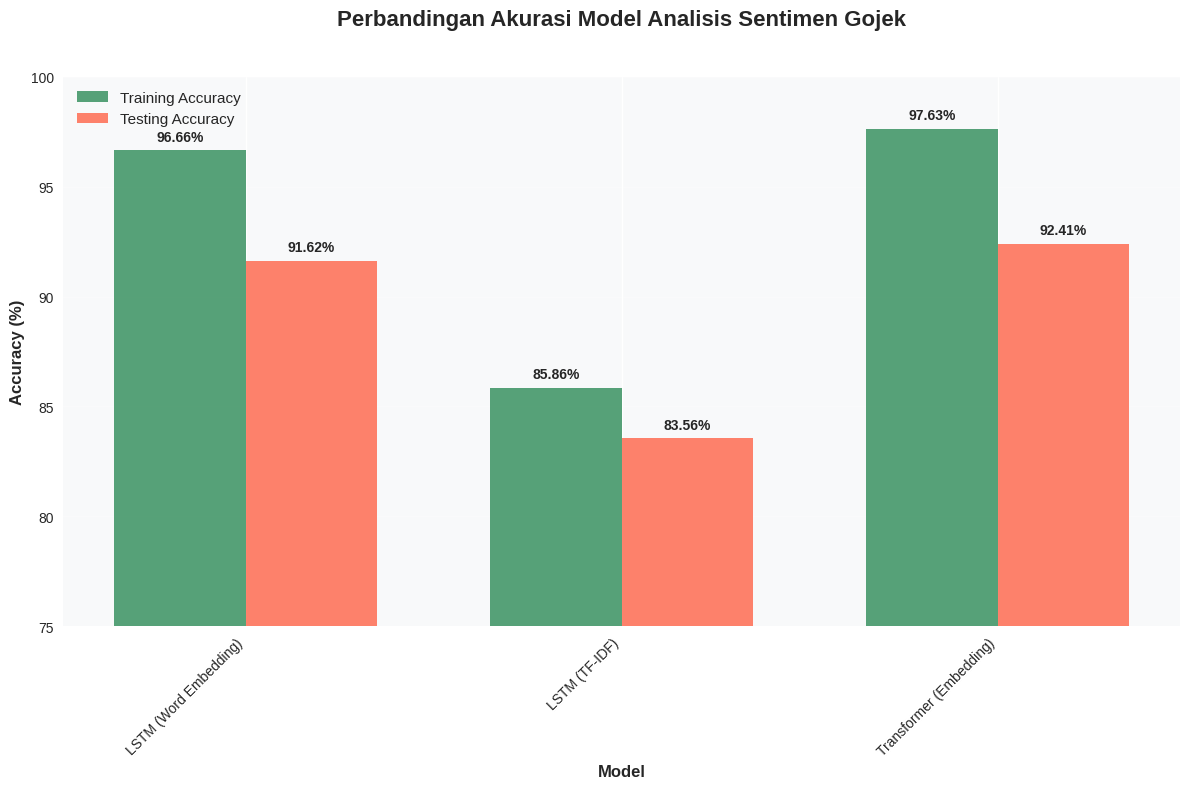

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data perbandingan model
model_data = {
    'Model': ['LSTM (Word Embedding)', 'LSTM (TF-IDF)', 'Transformer (Embedding)'],
    'Arsitektur': ['LSTM', 'LSTM', 'Transformer'],
    'Ekstraksi_Fitur': ['Word Embedding', 'TF-IDF', 'Embedding'],
    'Pembagian_Data': ['70/30', '80/20', '80/20'],
    'Training_Accuracy': [96.66, 85.86, 97.63],
    'Testing_Accuracy': [91.62, 83.56, 92.41]
}

df_models = pd.DataFrame(model_data)

# 1. Visualisasi Perbandingan Akurasi - Bar Chart dengan Dual Axis
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(df_models['Model']))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, df_models['Training_Accuracy'], width,
               label='Training Accuracy', alpha=0.8, color='#2E8B57')
bars2 = ax.bar(x + width/2, df_models['Testing_Accuracy'], width,
               label='Testing Accuracy', alpha=0.8, color='#FF6347')

# Customize chart
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Akurasi Model Analisis Sentimen Gojek\n',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_models['Model'], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(75, 100)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.2f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

add_value_labels(bars1)
add_value_labels(bars2)

# Add background color
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

| Model   | Arsitektur      | Ekstraksi Fitur  | Pembagian Data | Akurasi Training | Akurasi Testing |
|---------|------------------|------------------|----------------|------------------|-----------------|
| Model 1 | LSTM             | Word Embedding   | 70/30          | 96.66%           | 91.62%          |
| Model 2 | LSTM             | TF-IDF           | 80/20          | 85.86%           | 83.56%          |
| Model 3 | Transformers      | Embedding        | 80/20          | 97.63%           | 92.41%          |